In [1]:
from gen.sample_generator import data_generator, stock_data_generator, stacked_data_generator
import numpy as np
from prediction.auxPlot import *

# df = stacked_data_generator(start_date=(2023,1,1),
#                     end_date=(2023,2,2),
#                     perc_anomalies=0.08,
#                     regenerate=False
#                     )

df = stock_data_generator(start_date=(2023,1,1),
                    end_date=(2023,2,2),
                    perc_anomalies=0.08,
                    regenerate=False
                    )

Loading from filesystem c:\Users\manoj\Documents\MANOJ\Github\ML_PyTorch\data\stock_start_23_01_01_end_23_02_02_freq_5T_perc_0.08.csv


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9217 entries, 2023-01-01 00:00:00 to 2023-02-02 00:00:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   stock_1  9217 non-null   float64
 1   stock_2  9217 non-null   float64
dtypes: float64(2)
memory usage: 216.0 KB


In [3]:
df.head()

,stock_1,stock_2
datetime,,
2023-01-01 00:00:00,2.377889,0.032361
2023-01-01 00:05:00,2.227047,-0.807202
2023-01-01 00:10:00,2.022227,-1.426083
2023-01-01 00:15:00,1.799659,-1.836901
2023-01-01 00:20:00,1.595574,-2.052274


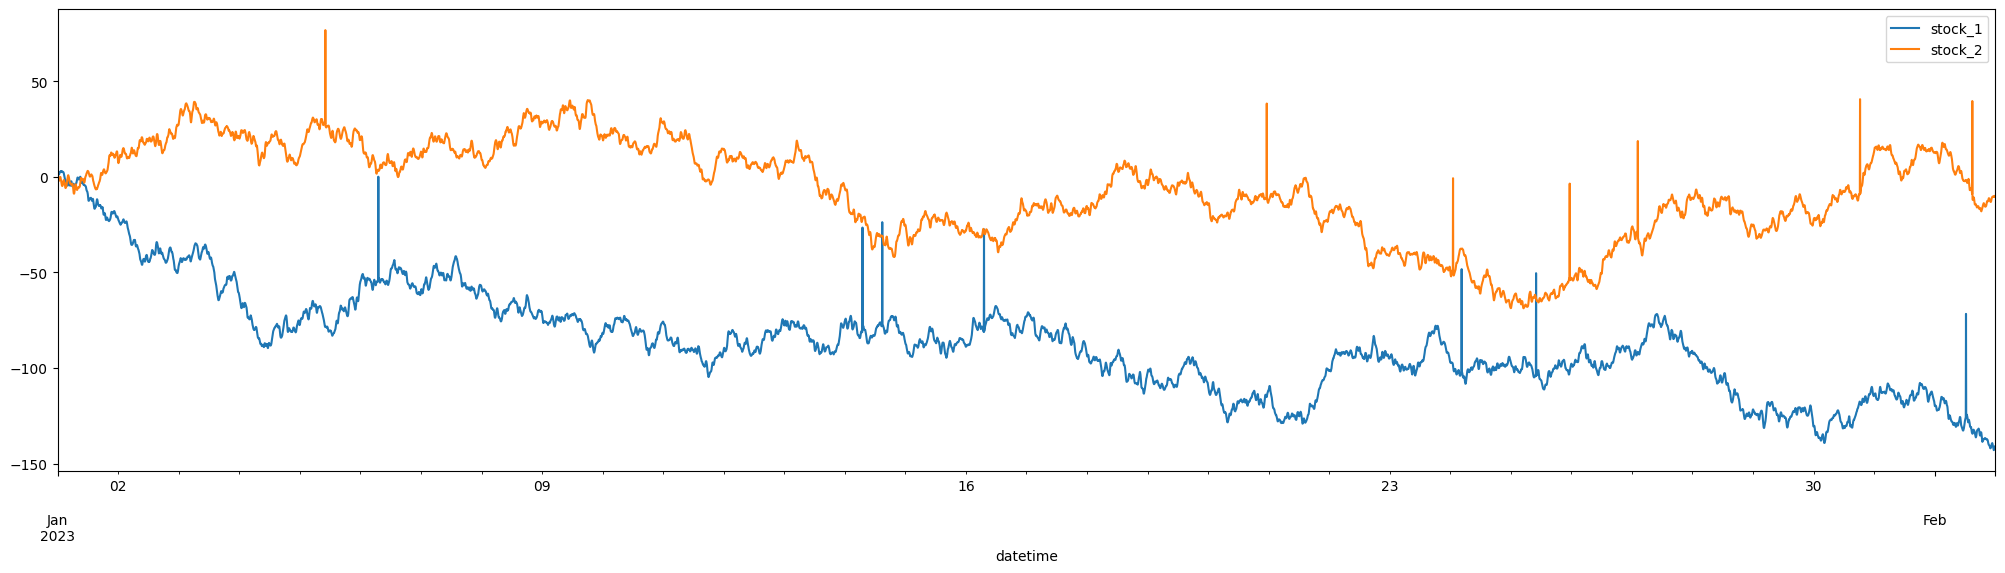

In [4]:
if 'dimension' in df.columns.to_list():
    df[df.dimension=='C'].plot(figsize=(25,6))
else:
    df.plot(figsize=(25,6))

In [5]:
selected_columns = df.columns.to_list()
if 'dimension' in df.columns.to_list():
    selected_columns.remove('dimension')

In [6]:
# Function to create windowed sequences
def create_windows(data, window_size, stride=1):
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)
    
    
# Calculate overall mean and std
all_metrics_data = df[selected_columns].to_numpy()

overall_mean, overall_std = np.mean(all_metrics_data, axis=0), np.std(all_metrics_data, axis=0)

In [7]:
# List to store windowed and normalized data for all cell_ids
X_list, y_list = [], []

window_size = 24

if 'dimension' in df.columns.to_list():
    for dim, group in df.groupby('dimension'):
        
        group = group.sort_index()
        # Select only the columns containing the metrics
        metrics_data = group[selected_columns].to_numpy()

        # Normalize the data using the overall mean and std
        metrics_data_normalized = (metrics_data - overall_mean) / overall_std

        # Create windowed sequences
        X_window, y_window = create_windows(metrics_data_normalized, window_size, stride=2)

        # Append to the list
        X_list.append(X_window)
        y_list.append(y_window)
else:
    metrics_data = df[selected_columns].to_numpy()

    # Normalize the data using the overall mean and std
    metrics_data_normalized = (metrics_data - overall_mean) / overall_std

    # Create windowed sequences
    X_window, y_window = create_windows(metrics_data_normalized, window_size, stride=2)

    # Append to the list
    X_list.append(X_window)
    y_list.append(y_window)

In [8]:
X_list = np.concatenate(X_list)
y_list = np.concatenate(y_list)

In [9]:
print(X_list.shape)
print(y_list.shape)

(4597, 24, 2)
(4597, 2)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

In [11]:
# Split the data into training and validation sets.
split_ratio = 0.8
split_index = int(len(X_list) * split_ratio)
X_train, y_train = X_list[:split_index], y_list[:split_index]
X_val, y_val = X_list[split_index:], y_list[split_index:]
print(X_train.shape)
print(y_train.shape)

(3677, 24, 2)
(3677, 2)


In [12]:
# Step 2: Define a PyTorch Dataset and DataLoader
from torch.utils.data import DataLoader, random_split, TensorDataset
from prediction.nn_models import TimeSeriesDataset

batch_size = 4096

train_dataset = TimeSeriesDataset(X_train, y_train,'Train',window_size=window_size, output_size=len(selected_columns))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TimeSeriesDataset(X_val,y_val,'Validation', window_size=window_size, output_size=len(selected_columns))
val_loader = DataLoader(val_dataset,batch_size=batch_size, shuffle=True)

In [13]:
# Reduced model hyperparameters
n_features = len(selected_columns)
num_layers = 3  # reduced from 3

learning_rate = 0.005
#batch_size = 32  # reduced from 64
other_params = {
    'window_size': window_size,
    'n_features': n_features,
    'layers': num_layers,
    'lr': learning_rate,
    'data_mean': overall_mean.tolist(),
    'data_std': overall_std.tolist()
    
}

from prediction.nn_models import LSTM_TimeSeriesModel_2
# Initialize the reduced Model, Loss, and Optimizer
# Now we can create a model and send it at once to the device
model = LSTM_TimeSeriesModel_2(n_features, num_layers, n_features)


loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# print(model.state_dict())

In [14]:
torch.cuda.set_per_process_memory_fraction(0.8)

In [15]:
from prediction.genericReg import *

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader,val_loader)
sbs.set_tensorboard('Anomaly')
sbs.add_graph()
sbs.train(n_epochs=1000, print_every=100)
sbs.save_checkpoint('model/model_checkpoint.pth', **other_params)

# print(model.state_dict())

Setting device: cuda
Epoch [100/1000]	Training-Loss: 0.2700	Validation-Loss: 0.4001
Epoch [200/1000]	Training-Loss: 0.0858	Validation-Loss: 0.1358
Epoch [300/1000]	Training-Loss: 0.0255	Validation-Loss: 0.0541
Epoch [400/1000]	Training-Loss: 0.0087	Validation-Loss: 0.0208
Epoch [500/1000]	Training-Loss: 0.0066	Validation-Loss: 0.0144
Epoch [600/1000]	Training-Loss: 0.0058	Validation-Loss: 0.0116
Epoch [700/1000]	Training-Loss: 0.0054	Validation-Loss: 0.0100
Epoch [800/1000]	Training-Loss: 0.0052	Validation-Loss: 0.0090
Epoch [900/1000]	Training-Loss: 0.0050	Validation-Loss: 0.0083
Epoch [1000/1000]	Training-Loss: 0.0048	Validation-Loss: 0.0078


In [16]:
# %tensorboard --port 7000 --logdir runs

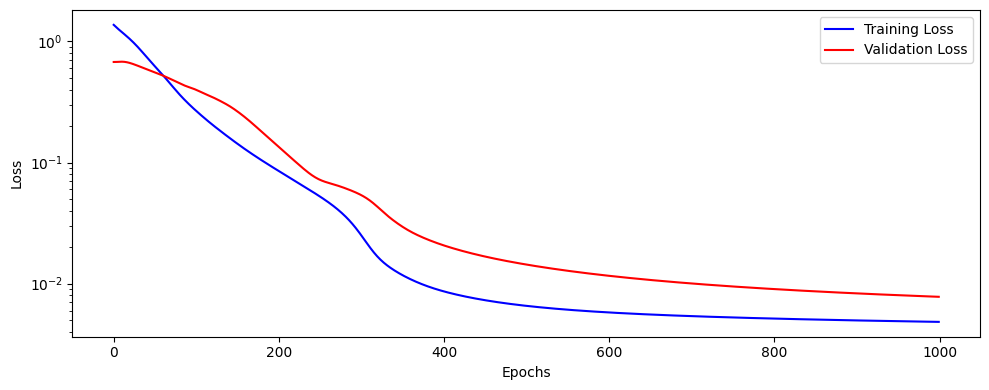

In [17]:
sbs.plot_losses()

In [18]:
sbs.generate_reconstruction_errors(bins=30)
print(sbs.reconstruction_loss_table)

                             bin_range  frequency
(-0.00194, 0.0648]  (-0.00194, 0.0648]        915
(0.0648, 0.13]          (0.0648, 0.13]          1
(0.13, 0.194]            (0.13, 0.194]          0
(0.194, 0.259]          (0.194, 0.259]          0
(0.259, 0.324]          (0.259, 0.324]          0
(0.324, 0.389]          (0.324, 0.389]          0
(0.389, 0.453]          (0.389, 0.453]          0
(0.453, 0.518]          (0.453, 0.518]          1
(0.518, 0.583]          (0.518, 0.583]          0
(0.583, 0.648]          (0.583, 0.648]          1
(0.648, 0.712]          (0.648, 0.712]          0
(0.712, 0.777]          (0.712, 0.777]          0
(0.777, 0.842]          (0.777, 0.842]          1
(0.842, 0.907]          (0.842, 0.907]          0
(0.907, 0.971]          (0.907, 0.971]          0
(0.971, 1.036]          (0.971, 1.036]          0
(1.036, 1.101]          (1.036, 1.101]          0
(1.101, 1.166]          (1.101, 1.166]          0
(1.166, 1.23]            (1.166, 1.23]          0


Perform the prediction on the entire dataset now for one of the dimension if it is present

In [19]:
if 'dimension' in df.columns.to_list():
    
    df_ml = df.loc[df['dimension']=='B']
    df_ml = df_ml.sort_index()
else:
    df_ml = df

In [20]:

new_metrics_data = df_ml[selected_columns].to_numpy()

# Using `create_windows` function to create windowed sequences
new_X_window, new_y_window = create_windows(new_metrics_data, window_size)

# Step 4: Normalize the windowed data using original mean and std
new_X_window_normalized = (new_X_window - overall_mean) / overall_std
new_y_window_normalized = (new_y_window - overall_mean) / overall_std



# Create DataLoader if needed
new_dataset = TimeSeriesDataset(new_X_window_normalized, new_y_window_normalized,'All data', window_size=window_size, output_size=len(selected_columns))
new_loader = DataLoader(new_dataset, batch_size=batch_size, shuffle=False)



In [21]:
sbs.val_loader = new_loader
sbs.construct_anomalies(percentile=99.5)

In [22]:
#Here we calculate the number of anomalies 
print(f"Number of anomalies: {sbs.anomalies.sum()}")

Number of anomalies: 37


## Visualize the Anomalies detected on the original data

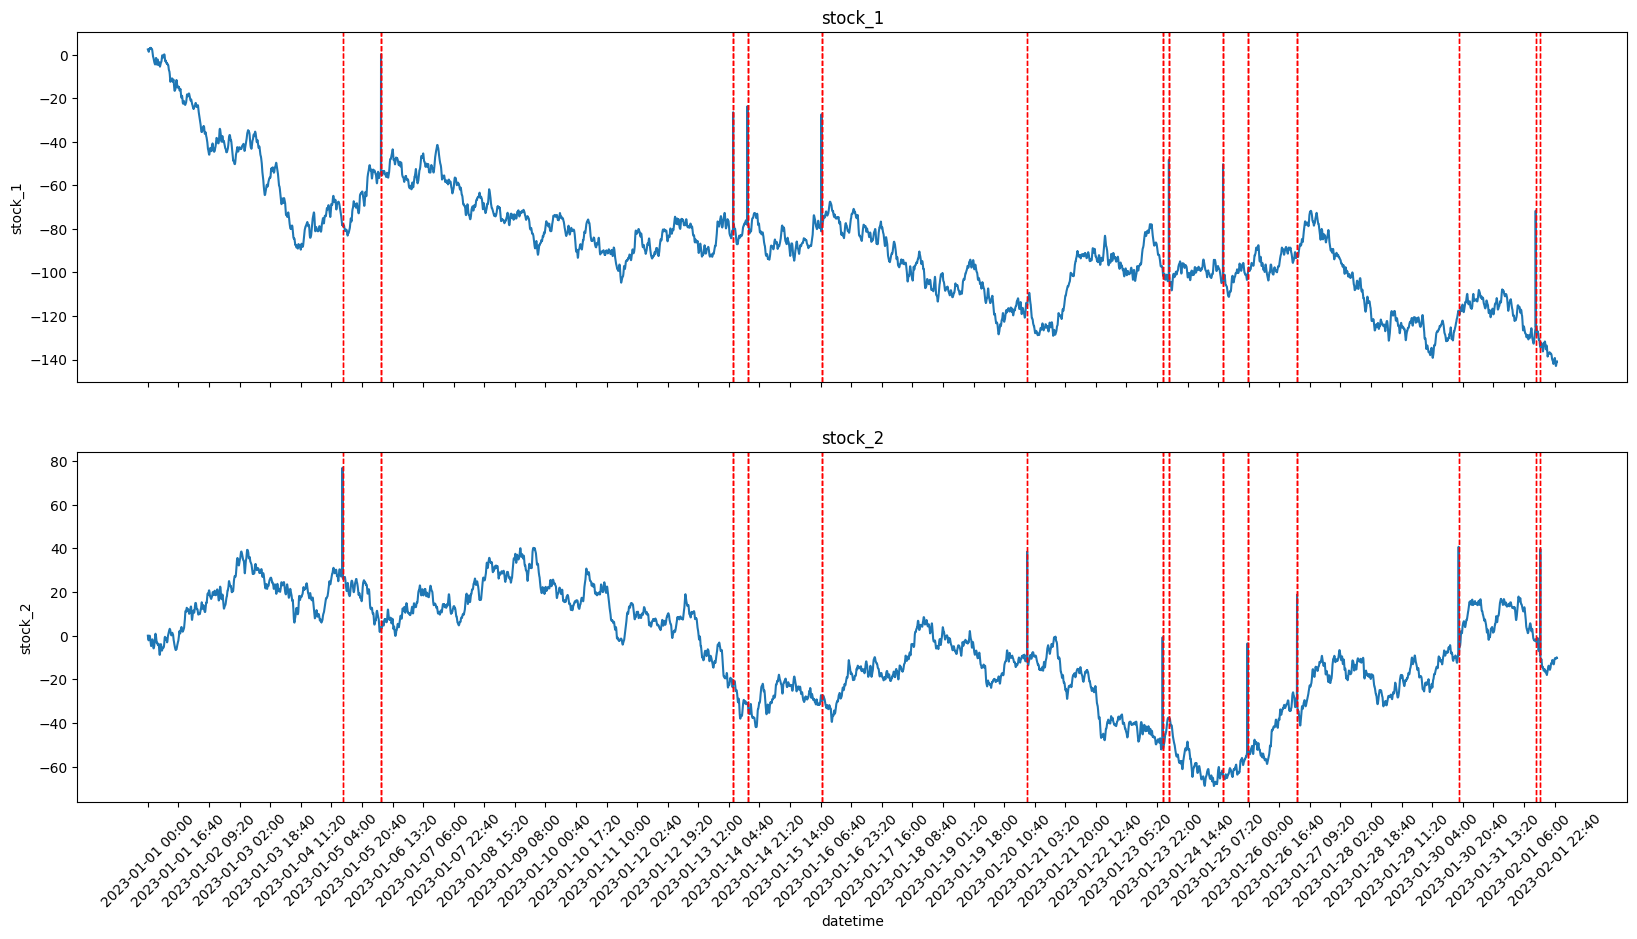

In [23]:

import matplotlib.pyplot as plt

# Prepare anomaly indices (same as previous examples)
anomalous_indexes_val = np.where(sbs.anomalies)[0]
original_anomalous_indexes = anomalous_indexes_val + window_size
anomaly_times = df_ml.index[original_anomalous_indexes]

stacked_lines_plots_w_anomalies(df_ml, metrics=selected_columns, anomaly_indices=anomaly_times)

## Export the model

In [24]:
sample_input = torch.randn(1, window_size, len(selected_columns))
torch.onnx.export(model,
                  sample_input.to(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')),
                  'model/model_onnx.onnx',
                  export_params=True,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'window_size'}, 
                                'output': {0: 'window_size'}}
                  )

c:\Users\manoj\Documents\MANOJ\Github\ML_PyTorch\venv\lib\site-packages\torch\onnx\symbolic_opset9.py:4662: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [25]:
# Export metadata
import json

data = {
    'window_size': window_size,
    'selected_columns': selected_columns,
    'overall_mean': overall_mean.tolist(),
    'overall_std': overall_std.tolist()
    }
with open('model/model_data.json', 'w') as f:
    json.dump(data, f)